<a href="https://colab.research.google.com/github/AlinFin/Tumor/blob/main/brain_tumor_modified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Brain Tumor classification** (finall project)
###Alin Finkelshtein and Felix Doctorman

## We are dealing with 3 types of brain tumors : glioma, meningioma and pituitary adenoma along with no- tumor ( healthy brain). The brain tumors in our data are among most common brain tumors. Thus, the neurosurgents meet them quite often. Moreover, some of them can look quite similar in some cases. Thus, the motivation of this project is to ease the classification and diminish the number of mistakes between the tumors.

# **The data:**
##We are dealing with MRI images. The aim of MRI is to screen the brian in several axis : Up to down, front to back and left to right. Each time the frames will start on one side and go deeper inside the tissue until reaching the other side. Thus, the data contains ~ 20 images per person. However, we don't have the information which images belong to which person in our data.

# **The model**
##The aim of the model is to predict the probability of each class per image.

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)



In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import time
import torch

from sklearn.model_selection import train_test_split
import random
from tqdm import tqdm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# For ML Models
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input, decode_predictions
from tensorflow.keras import regularizers
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from sklearn.metrics import confusion_matrix
import itertools
import pydot
import graphviz
from keras.utils import to_categorical



In [ ]:
!pip install kaggle

In [ ]:
#move the uploaded kaglle jason to the appropriate location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

100% 148M/149M [00:09<00:00, 22.2MB/s]
100% 149M/149M [00:09<00:00, 17.2MB/s]


In [ ]:
!unzip brain-tumor-mri-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/

In [ ]:
# Define the path to the test and train datasets
train_dir = 'Training'
test_dir='Testing'

In [ ]:
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']

In [ ]:
# Go over the train dataset:
for i in categories:
    path = os.path.join(train_dir, i)
    for img in os.listdir(path):
        img_array_train = cv2.imread(os.path.join(path,img))

# Go over the test dataset:
for i in categories:
    path = os.path.join(test_dir, i)
    for img in os.listdir(path):
        img_array_test = cv2.imread(os.path.join(path,img))

In [ ]:
#This is size of each image - 512x512 with 3 channels (RGB)
print(img_array_train.shape)
print(img_array_test.shape)

(512, 512, 3)
(512, 512, 3)


In [ ]:
#Count the number of files in each directory

# Get a list of all files and folders in the directory
files_and_folders = os.listdir(train_dir) # ['glioma', 'meningioma', 'notumor', 'pituitary']
files_and_folders1 = os.listdir(test_dir)


# Count the number of pictures in each folder
train_categories = []
train_counts = []
for folder in files_and_folders:
    folder_path = os.path.join(train_dir, folder)
    num_pictures = len(os.listdir(folder_path))
    train_categories.append(folder)
    train_counts.append(num_pictures)
    print(f"Number of pictures in train folder {folder}: {num_pictures}")


# Count the number of pictures in each folder for testing dataset
test_categories = []
test_counts = []
for folder in files_and_folders1:
    folder_path = os.path.join(test_dir, folder)
    num_pictures = len(os.listdir(folder_path))
    test_categories.append(folder)
    test_counts.append(num_pictures)
    print(f"Number of pictures in test folder {folder}: {num_pictures}")



Number of pictures in train folder notumor: 1595
Number of pictures in train folder glioma: 1321
Number of pictures in train folder meningioma: 1339
Number of pictures in train folder pituitary: 1457
Number of pictures in test folder notumor: 405
Number of pictures in test folder glioma: 300
Number of pictures in test folder meningioma: 306
Number of pictures in test folder pituitary: 300


## Visualize the data: 1.Is it balansed? 2.That is the ratio between train and test datasets?


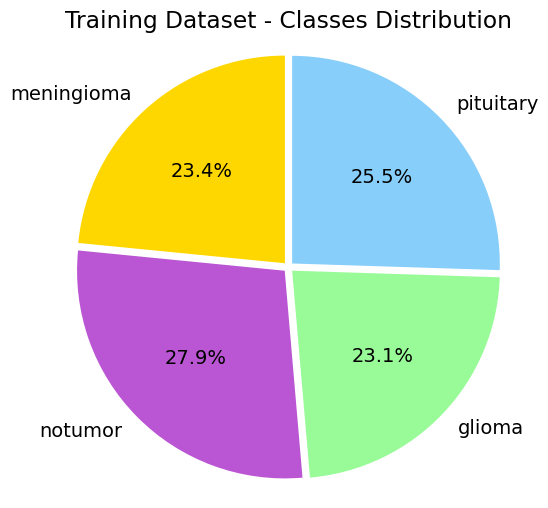

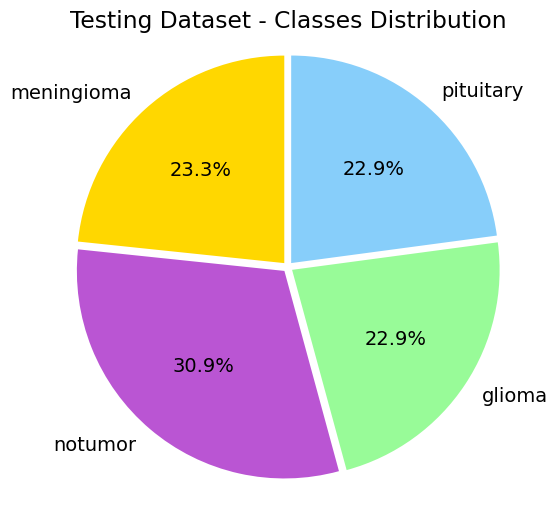

In [ ]:
# Define custom colors for the pie chart

colors = ['gold', 'mediumorchid', 'palegreen', 'lightskyblue']

# Create a pie chart for the training dataset
plt.figure(figsize=(6, 6))
plt.rcParams.update({'font.size':14})
plt.pie(train_counts, labels=train_categories,colors=colors, autopct='%1.1f%%', explode=(0.025,0.025, 0.025,0.025),startangle=90)
plt.title('Training Dataset - Classes Distribution')
plt.axis('equal')
plt.show()

# Create a pie chart for the testing dataset
plt.figure(figsize=(6, 6))
plt.rcParams.update({'font.size':14})
plt.pie(test_counts, labels=test_categories,colors=colors, autopct='%1.1f%%', explode=(0.025,0.025, 0.025,0.025),startangle=90)
plt.title('Testing Dataset - Classes Distribution')
plt.axis('equal')
plt.show()


### The data is balanced.

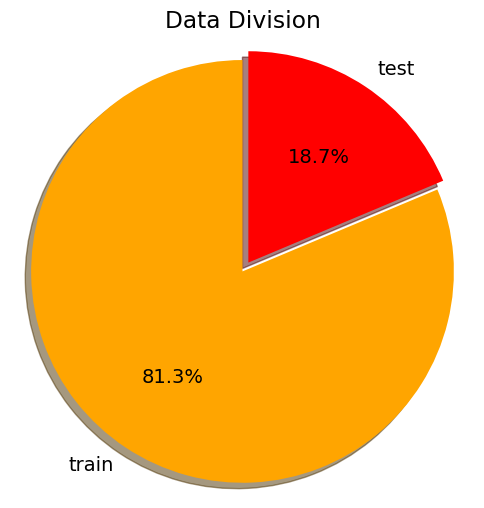

5712 1311


In [ ]:
# That is the proportion of train and test

# The total number of pictures in train and test
train_size=sum(train_counts)
test_size= sum(test_counts)

colors = ['orange', 'red']

plt.figure(figsize=(6, 6))
plt.rcParams.update({'font.size': 14})
plt.pie([train_size, test_size], labels=['train', 'test'], colors=colors, autopct='%1.1f%%', explode=(0.05, 0),
        startangle=90, shadow=True)
plt.title('Data Division')
plt.axis('equal')
plt.show()

print(train_size, test_size)

## Lets see some samples of the classes

### Example of Normal brain

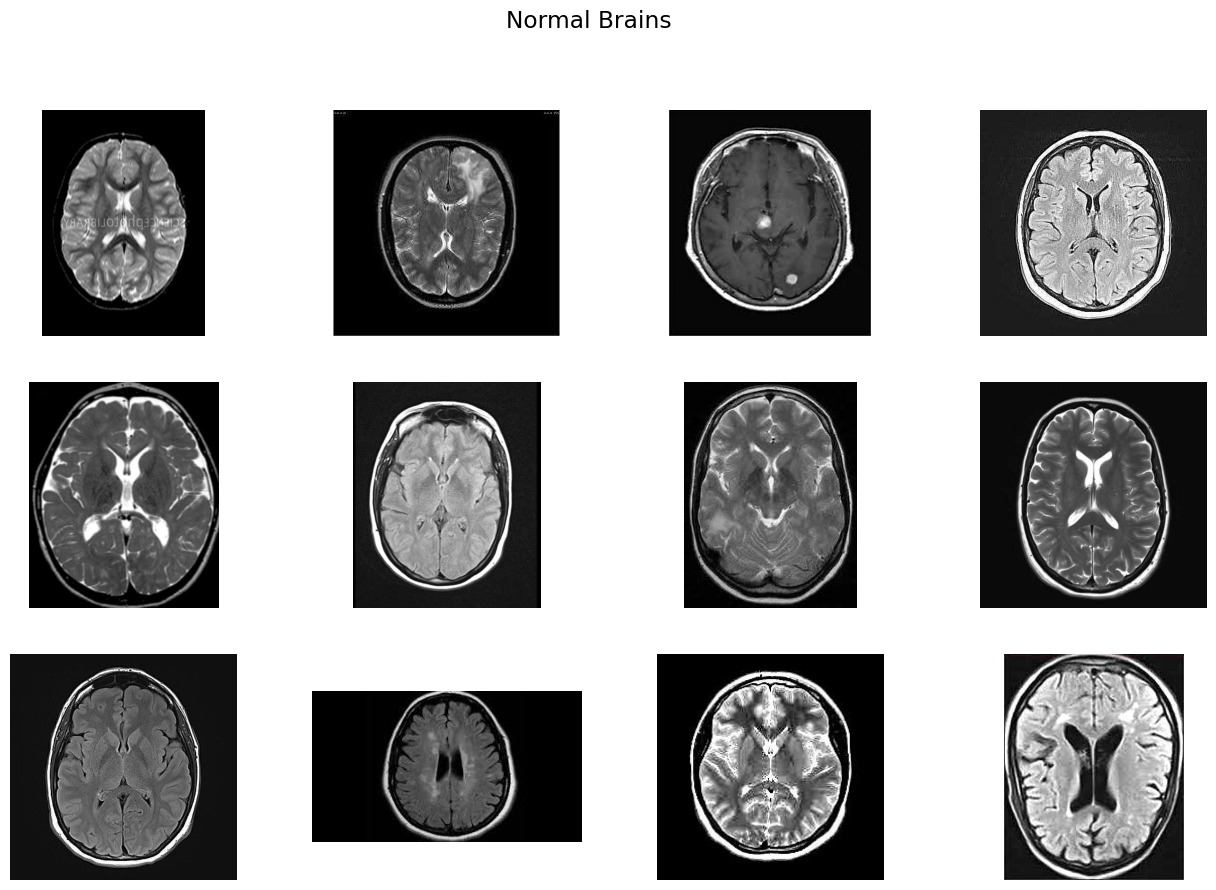

In [ ]:
notumor_dir = 'Training/notumor'

# Get a list of all image files in the "notumor" category
image_files = os.listdir(notumor_dir)

# Randomly select 9 images
selected_images = random.sample(image_files, 12)

fig = plt.figure(figsize=(16, 10))
fig.suptitle('Normal Brains')

for i, filename in enumerate(selected_images):
    ax = plt.subplot(3,4, i + 1)
    img = cv2.imread(os.path.join(notumor_dir, filename))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')

plt.show()

### Glioma Tumor

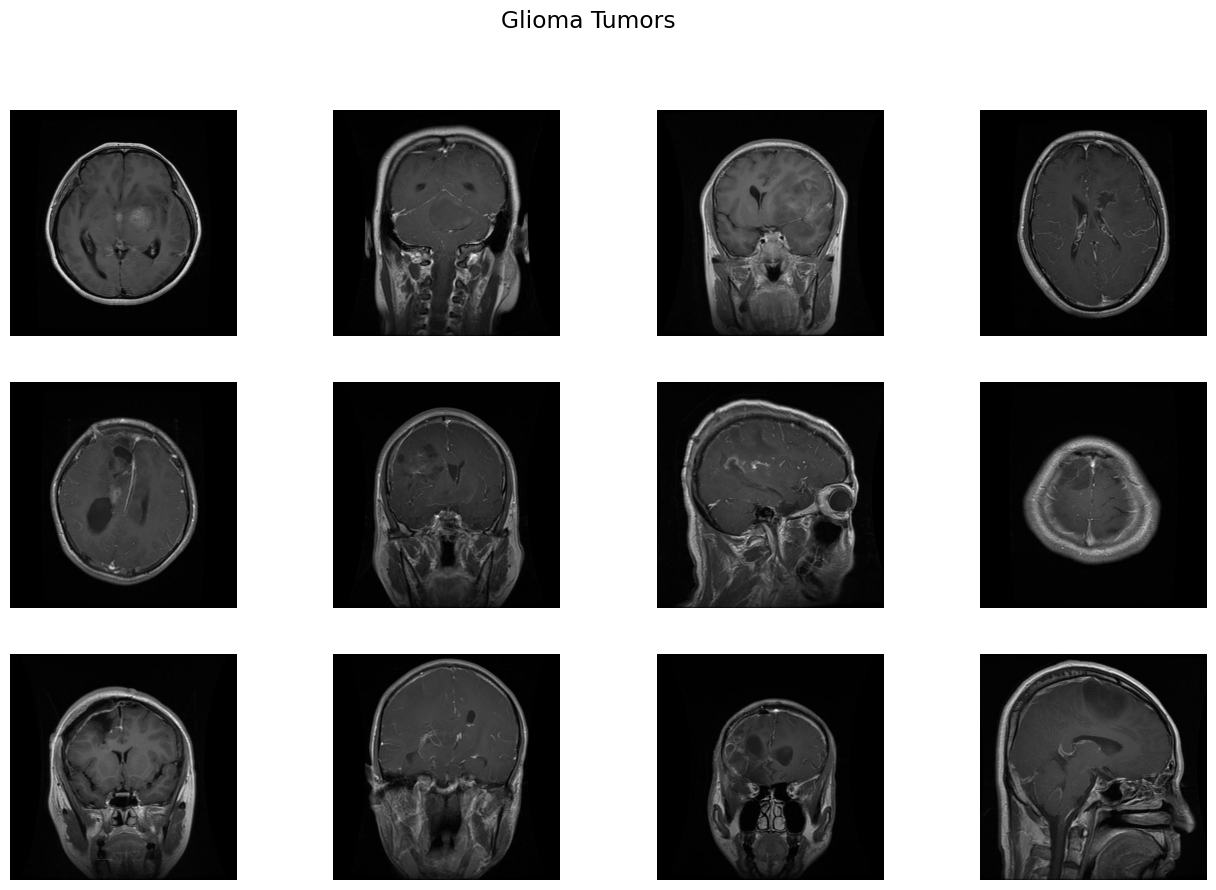

In [ ]:
notumor_dir = 'Training/glioma'

# Get a list of all image files in the "notumor" category
image_files = os.listdir(notumor_dir)

# Randomly select 9 images
selected_images = random.sample(image_files, 12)

fig = plt.figure(figsize=(16, 10))
fig.suptitle('Glioma Tumors')

for i, filename in enumerate(selected_images):
    ax = plt.subplot(3,4, i + 1)
    img = cv2.imread(os.path.join(notumor_dir, filename))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')

plt.show()

### Meningioma Tumor

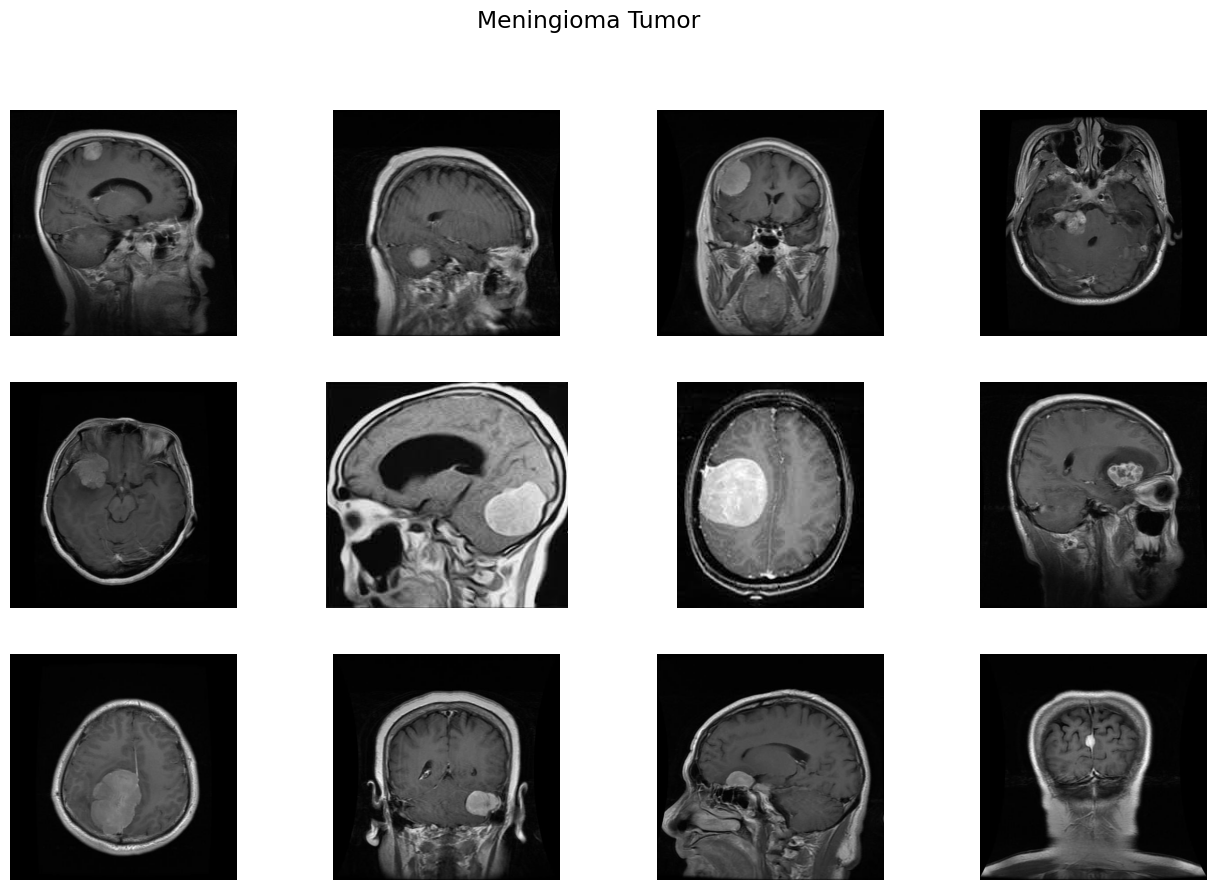

In [ ]:
meningioma_dir = 'Training/meningioma'

# Get a list of all image files in the "notumor" category
image_files = os.listdir(meningioma_dir )

# Randomly select 9 images
selected_images = random.sample(image_files, 12)

fig = plt.figure(figsize=(16, 10))
fig.suptitle('Meningioma Tumor')

x=10

for i, filename in enumerate(selected_images):
    ax = plt.subplot(3, 4, i + 1)
    img = cv2.imread(os.path.join(meningioma_dir , filename))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')

plt.show()


### Pituitary Tumor

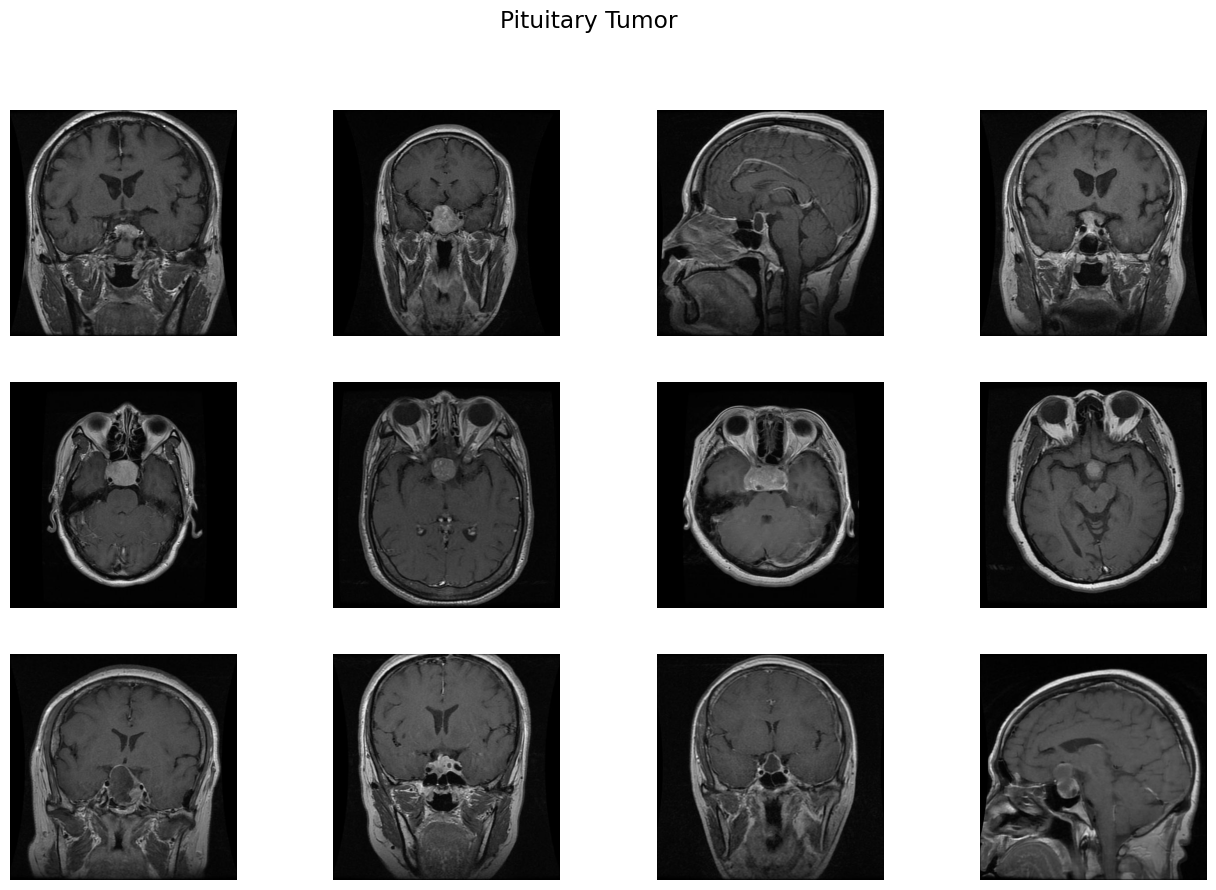

In [ ]:
pituitary_dir = 'Training/pituitary'

# Get a list of all image files in the "notumor" category
image_files = os.listdir(pituitary_dir )

# Randomly select 9 images
selected_images = random.sample(image_files, 12)

fig = plt.figure(figsize=(16, 10))
fig.suptitle('Pituitary Tumor')

x=10

for i, filename in enumerate(selected_images):
    ax = plt.subplot(3, 4, i + 1)
    img = cv2.imread(os.path.join(pituitary_dir , filename))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')

plt.show()


## Data preprocessing

In [ ]:
#Image resize to 128 to 128
img_size = 128
image_array_train = cv2.resize(img_array_train, (img_size,img_size))
image_array_test = cv2.resize(img_array_test, (img_size,img_size))

### Convert each image to grayscale and append into an array

In [ ]:
#Conversion to gray scale image using cv2.IMREAD_GRAYSCALE argument and creation of train data
#Each element of list contains image vector representation in place 0 and classification label in place 1
train_data = []

for i in categories:
    train_path = os.path.join(train_dir,i)
    tag = categories.index(i)
    for img in os.listdir(train_path):
        try:
            image_arr = cv2.imread(os.path.join(train_path , img), cv2.IMREAD_GRAYSCALE)
            new_image_array = cv2.resize(image_arr, (img_size,img_size))
            train_data.append([new_image_array , tag])
        except Exception as e:
            pass

In [ ]:
# convert to gray scale the test array
test_data = []

for i in categories:
    test_path = os.path.join(test_dir,i)
    tag = categories.index(i)
    for img in os.listdir(test_path):
        try:
            image_arr = cv2.imread(os.path.join(test_path , img), cv2.IMREAD_GRAYSCALE)
            new_image_array = cv2.resize(image_arr, (img_size,img_size))
            test_data.append([new_image_array , tag])
        except Exception as e:
            pass


## Split the features and target in to X and y

In [ ]:
#Train data
X = []
y = []
for i,j in train_data:
    X.append(i)
    y.append(j)
X = np.array(X).reshape(-1,img_size,img_size)
print(X.shape)
#print(X[0])
X = X/255.0
#print(X[0])
X = X.reshape(-1,128,128,1)
print(X.shape)


(5712, 128, 128)
(5712, 128, 128, 1)


In [ ]:
#Convert train labels to categorical
y_train = to_categorical(y, num_classes = 4)

In [ ]:
# Test data
X_test = []
y_test = []
for i,j in test_data:
    X_test.append(i)
    y_test.append(j)
X_test = np.array(X_test).reshape(-1,img_size,img_size)
print(X_test.shape)

X_test = X_test/255.0

X_test = X_test.reshape(-1,128,128,1)
print(X_test.shape)



(1311, 128, 128)
(1311, 128, 128, 1)


In [ ]:
#Convert test labels to categorical
y_test = to_categorical(y_test, num_classes = 4)
print(np.array(y_test).shape)

(1311, 4)


### Split train data  into train and validation  (80%-20%)

In [ ]:

X_train , X_val, y_train, y_val = train_test_split(X , y , test_size = 0.2, random_state = 42)
num_classes = 4
y_train = to_categorical(y_train, num_classes=num_classes)
y_val = to_categorical(y_val, num_classes=num_classes)

# Check the shapes of the resulting arrays
print(X_train.shape)
print(X_val.shape)
print(np.array(y_train).shape)
print(np.array(y_val).shape)



(4569, 128, 128, 1)
(1143, 128, 128, 1)
(4569, 4)
(1143, 4)


## Import keras' functions to create CNN model

In [ ]:
# Create a list to store the results
results = []


# Define a function to run and evaluate each model
def run_model_and_evaluate(model_name, model):
    # Train the model and measure the training time
    start_time = time.time()
    # ... Train the model ...
    training_time = time.time() - start_time

    # After training, calculate the metrics (accuracy, recall, precision, f1 score)
    # ... Calculate the metrics ...

    # Store the results in a dictionary
    result = {
        'Model Name': model_name,
        'Accuracy': accuracy,
        'Recall': recall,
        'Precision': precision,
        'F1 Score': f1_score,
        'Training Time': training_time
    }

    # Append the result dictionary to the result_list
    result_list.append(result)


In [ ]:
!pip install pydot

In [ ]:
!pip install graphviz

In [ ]:
# Create a list to store the results
results = []

# CNN model
model = Sequential()


model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (128,128,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))


model.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(1024, activation = "relu"))
model.add(Dropout(0.5))

model.add(Dense(4, activation = "softmax"))

optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

epochs = 12

es = EarlyStopping(
    monitor='loss',
    mode='max',
    patience = 15
)

batch_size = 16
imggen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=0,
        zoom_range = 0,
        width_shift_range=0,
        height_shift_range=0,
        horizontal_flip=True,
        vertical_flip=False)

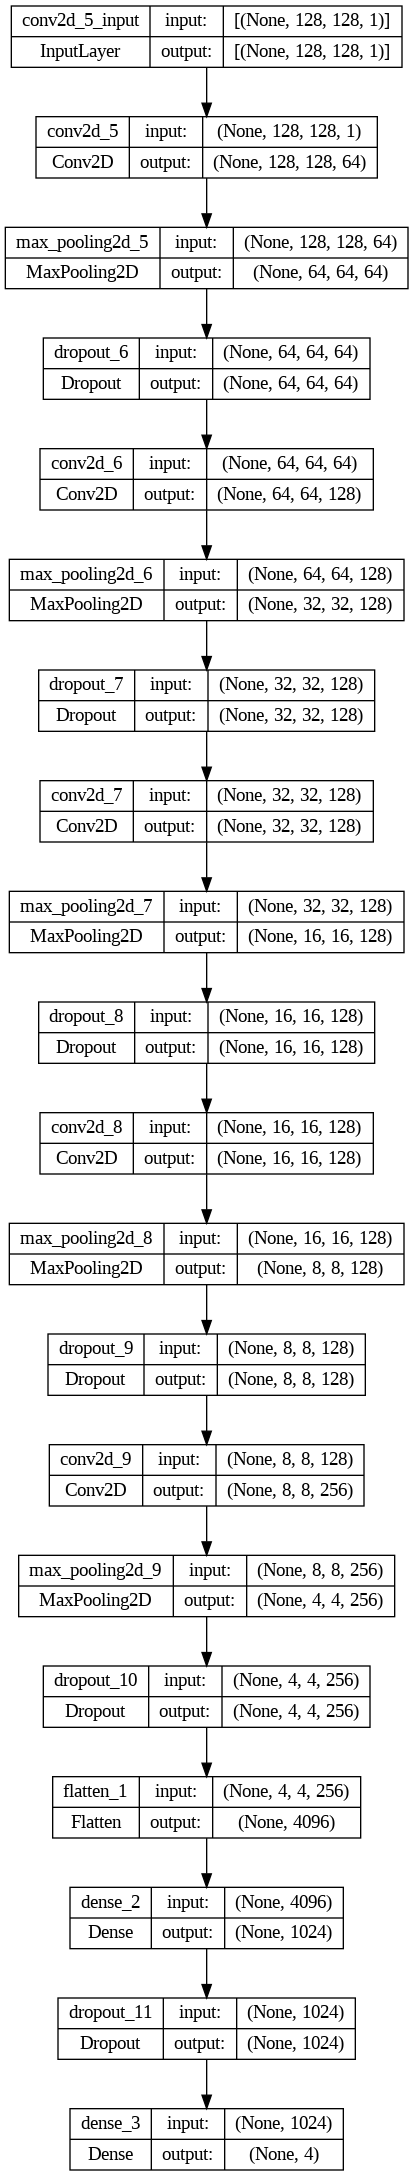

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1664      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 128)       0

## Fit the model with Train and Validation datatsets

In [ ]:

start_time = time.time()

# Fitting the model to the data
history_cnn = model.fit(
        imggen.flow(X_train, y_train, batch_size=batch_size),
        epochs=epochs,
        validation_data=(X_val, y_val),
        steps_per_epoch=X_train.shape[0] // batch_size,
        callbacks=[es]
    )

training_time = time.time() - start_time


Epoch 1/12
285/285 [==============================] - 27s 41ms/step - loss: 0.9063 - accuracy: 0.6051 - val_loss: 0.7804 - val_accuracy: 0.6579
Epoch 2/12
285/285 [==============================] - 7s 25ms/step - loss: 0.5640 - accuracy: 0.7749 - val_loss: 0.4674 - val_accuracy: 0.8224
Epoch 3/12
285/285 [==============================] - 7s 25ms/step - loss: 0.4530 - accuracy: 0.8245 - val_loss: 0.5044 - val_accuracy: 0.8128
Epoch 4/12
285/285 [==============================] - 7s 25ms/step - loss: 0.3942 - accuracy: 0.8504 - val_loss: 0.4355 - val_accuracy: 0.8066
Epoch 5/12
285/285 [==============================] - 7s 24ms/step - loss: 0.3260 - accuracy: 0.8832 - val_loss: 0.2920 - val_accuracy: 0.8915
Epoch 6/12
285/285 [==============================] - 7s 24ms/step - loss: 0.2794 - accuracy: 0.8992 - val_loss: 0.2862 - val_accuracy: 0.8915
Epoch 7/12
285/285 [==============================] - 7s 25ms/step - loss: 0.2357 - accuracy: 0.9159 - val_loss: 0.2487 - val_accuracy: 0.906

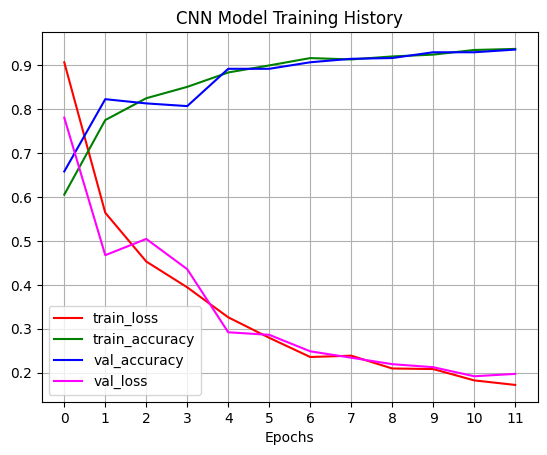

In [ ]:
#Plot the accuracy vs loss for both train and validation

plt.plot(history_cnn.history["loss"],c = "red")
plt.plot(history_cnn.history["accuracy"],c = "green")
plt.plot(history_cnn.history['val_accuracy'], c = "blue")
plt.plot(history_cnn.history['val_loss'], c = "magenta")
plt.grid(True)
plt.title("CNN Model Training History")
plt.xlabel("Epochs")
plt.xticks([x for x in range(epochs)])
plt.legend(["train_loss", "train_accuracy",'val_accuracy','val_loss'])
plt.rcParams["figure.figsize"] = (7,8)
plt.show()

## Validation with test samples

In [ ]:
score=model.evaluate(X_test, y_test, verbose=0)
print('Test loss', score[0])
print('Test accuracy:',score[1])

Test loss 0.2724289000034332
Test accuracy: 0.8962624073028564


##Create classification report

In [ ]:
# Make predictions on the test data
y_pred_prob = model.predict(X_test)

# Convert predicted probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# If your y_test is one-hot encoded, you may need to convert it to class labels as well
y_true = np.argmax(y_test, axis=1)

# Define your class labels
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=categories)

# Print the classification report
print(report)

41/41 [==============================] - 1s 10ms/step
              precision    recall  f1-score   support

      glioma       0.95      0.84      0.89       300
  meningioma       0.80      0.75      0.78       306
     notumor       0.87      0.99      0.93       405
   pituitary       0.97      0.98      0.98       300

    accuracy                           0.90      1311
   macro avg       0.90      0.89      0.89      1311
weighted avg       0.90      0.90      0.89      1311



## Generate the confusion matrix

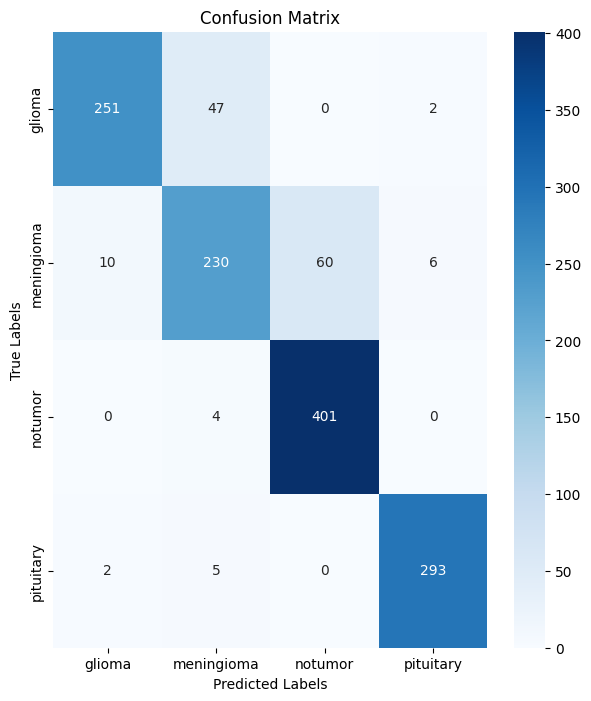

In [ ]:

conf_matrix = confusion_matrix(y_true, y_pred)

# Define class labels (if you have specific class labels)
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']
class_labels = categories

# Create a heatmap using Seaborn
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

In [ ]:
# Fill the comparishon table with CNN parameters

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Calculate precision
precision = precision_score(y_true, y_pred, average='weighted')  # or 'macro' or 'micro' depending on your needs

# Calculate recall
recall = recall_score(y_true, y_pred, average='weighted')  # or 'macro' or 'micro' depending on your needs

# Calculate F1 score
f1 = f1_score(y_true, y_pred, average='weighted')  # or 'macro' or 'micro' depending on your needs

# Store the results in a dictionary
result = {
        'Model Name': 'CNN',
        'Accuracy': accuracy,
        'Recall': recall,
        'Precision': precision,
        'F1 Score': f1,
        'Training Time': training_time
    }

    # Append the result dictionary to the result_list
results.append(result)


df_results = pd.DataFrame(results)

# Display the DataFrame
df_results


Model Name  Accuracy    Recall  Precision  F1 Score  Training Time
0        CNN  0.896262  0.896262   0.897567  0.894621     138.524318

## Save the trained model

In [ ]:
# Save the entire model (architecture, weights, and optimizer state) to a file
model.save("C:/Users/ALIN/Desktop/Python_Alin/finall project_NN/CNN_Brain_trained.h5")


## Load the pretrained model to use it further

In [ ]:
# To load the entire model (architecture, weights, and optimizer state) from the saved file
cnn_model = tf.keras.models.load_model("C:/Users/ALIN/Desktop/Python_Alin/finall project_NN/CNN_Brain_trained.h5")

# Get the output probabilities for the test data
y_proba = cnn_model.predict(X_test)

y_proba.shape

41/41 [==============================] - 1s 10ms/step


(1311, 4)

In [ ]:
# Make predictions on the test data
y_pred_prob = cnn_model.predict(X_test)

# Convert predicted probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# If your y_test is one-hot encoded, you may need to convert it to class labels as well
y_true = np.argmax(y_test, axis=1)


# Generate the classification report
report = classification_report(y_true, y_pred, target_names=categories)

# Print the classification report
print(report)

41/41 [==============================] - 0s 10ms/step
              precision    recall  f1-score   support

      glioma       0.95      0.84      0.89       300
  meningioma       0.80      0.75      0.78       306
     notumor       0.87      0.99      0.93       405
   pituitary       0.97      0.98      0.98       300

    accuracy                           0.90      1311
   macro avg       0.90      0.89      0.89      1311
weighted avg       0.90      0.90      0.89      1311



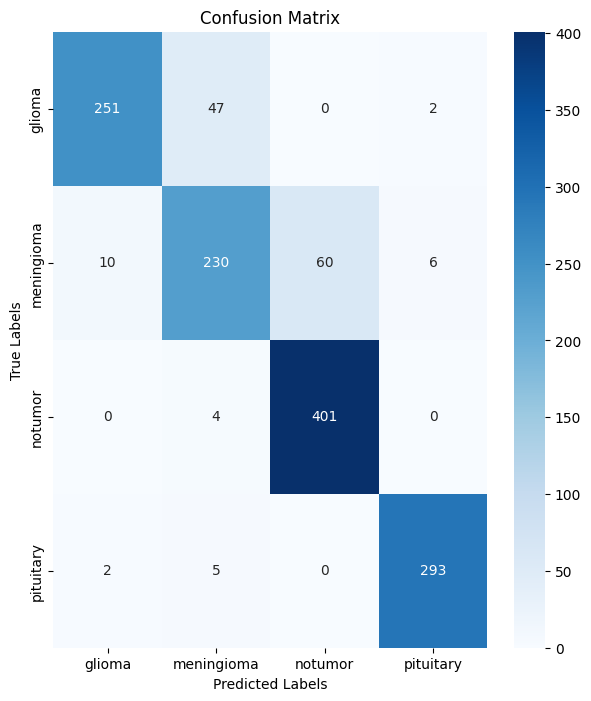

In [ ]:
conf_matrix = confusion_matrix(y_true, y_pred)

# Define class labels (if you have specific class labels)
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']
class_labels = categories

# Create a heatmap using Seaborn
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

## Lets make an ensemble modeling by applying the results to XGBoost

In [ ]:
# Create a new model that outputs the output of the dense layer
layer_name = 'dense'  #
new_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

# Use the new model to extract features from your input data
X_train_features = new_model.predict(X_train)
X_test_features = new_model.predict(X_test)

print(X_train_features.shape)
print(X_test_features.shape)


41/41 [==============================] - 0s 7ms/step
(4569, 1024)
(1311, 1024)


In [ ]:
y_pred = np.argmax(y_proba, axis=1)

In [ ]:
from xgboost import XGBClassifier


In [ ]:
#Train the XGBoost model

start_time = time.time()

xgb = XGBClassifier(objective='multiclass:softmax', learning_rate = 0.1,
              max_depth = 15, n_estimators = 500)
xgb.fit(X_train_features,np.argmax(y_train, axis=1))


training_time = time.time() - start_time

In [ ]:
XGBClassifier(max_depth=15, n_estimators=500, objective='multi:softprob')

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [ ]:
#Validation
X_test_features = new_model.predict(X_test)

41/41 [==============================] - 0s 8ms/step


In [ ]:

y_pred = xgb.predict(X_test_features)

In [ ]:
y_test = np.argmax(y_test, axis =1)

In [ ]:
#Test accuracy
from sklearn.metrics import accuracy_score as ac
ac(y_pred, y_test)

0.9412662090007627

In [ ]:
#Classification report for XGBoost

# Define your class labels
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Generate the classification report with custom labels
report = classification_report(y_true, y_pred, target_names=categories)

# Print the classification report
print(report)

              precision    recall  f1-score   support

      glioma       0.95      0.87      0.90       300
  meningioma       0.87      0.90      0.89       306
     notumor       0.97      0.99      0.98       405
   pituitary       0.97      0.99      0.98       300

    accuracy                           0.94      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.94      0.94      0.94      1311



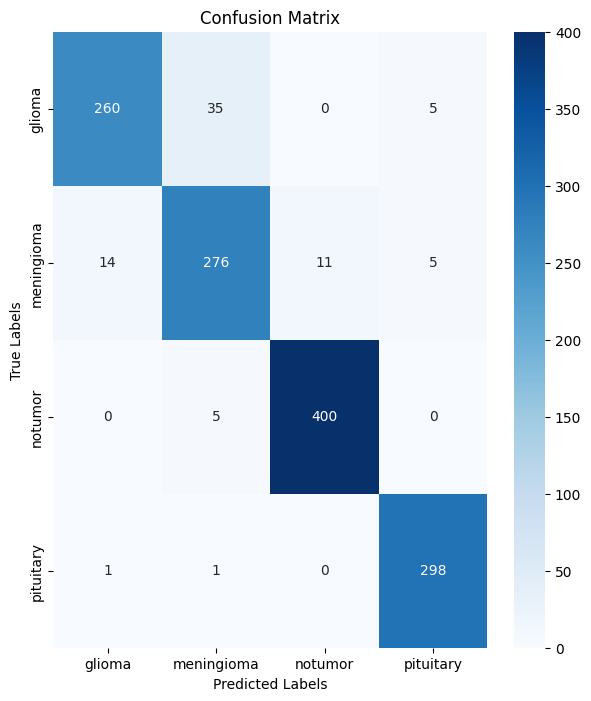

In [ ]:
#confusion_matrix for XGBoost

conf_matrix = confusion_matrix(y_true, y_pred)

# Define class labels (if you have specific class labels)
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']
class_labels = categories


# Create a heatmap using Seaborn
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

In [ ]:
#load XGBoost parameters into comparishon table

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Calculate precision
precision = precision_score(y_true, y_pred, average='weighted')  # or 'macro' or 'micro' depending on your needs

# Calculate recall
recall = recall_score(y_true, y_pred, average='weighted')  # or 'macro' or 'micro' depending on your needs

# Calculate F1 score
f1 = f1_score(y_true, y_pred, average='weighted')  # or 'macro' or 'micro' depending on your needs

# Store the results in a dictionary
result = {
        'Model Name': 'CNN +XGBoost',
        'Accuracy': accuracy,
        'Recall': recall,
        'Precision': precision,
        'F1 Score': f1,
        'Training Time': training_time
    }

    # Append the result dictionary to the result_list
results.append(result)


# # Create a DataFrame from the results
df_results = pd.DataFrame(results)

# Display the DataFrame
df_results


Model Name  Accuracy    Recall  Precision  F1 Score  Training Time
0           CNN  0.896262  0.896262   0.897567  0.894621     138.524318
1  CNN +XGBoost  0.941266  0.941266   0.941632  0.940937     318.695272

# VGG16

### VGG requires shape ( heihg, weight, 3), so create train and test data without reshaping the RGB

## Data pretreatment


In [ ]:
# VGG 16 requires a different shape with RGB - create it.
img_size = 128
train_data = []

for category_index, category in enumerate(categories):
    train_path = os.path.join(train_dir, category)
    try:
        for img_filename in os.listdir(train_path):
            image = cv2.imread(os.path.join(train_path, img_filename))
            resized_image = cv2.resize(image, (img_size, img_size))
            train_data.append((resized_image, category_index))
    except Exception as e:
        pass

# Convert labels to categorical
y_train1 = to_categorical([label for _, label in train_data], num_classes=4)

# Split data into X and y
X_train1 = np.array([image for image, _ in train_data])

print(X_train1.shape)  # Should be (number_of_samples, 128, 128, 3)
print(y_train1.shape)  # Should be (number_of_samples, 4)

(5712, 128, 128, 3)
(5712, 4)


In [ ]:
X_train1, X_val1, y_train1, y_val1 = train_test_split(X_train1, y_train1, test_size=0.2, random_state=42)

print(X_train1.shape)
print(X_val1.shape)
print(y_train1.shape)
print(y_val1.shape)

(4569, 128, 128, 3)
(1143, 128, 128, 3)
(4569, 4)
(1143, 4)


In [ ]:
y_train_int = np.argmax(y_train1, axis=1)
y_val_int=np.argmax(y_val1, axis=1)
unique_labels = np.unique(y_train_int)
print(unique_labels)

[0 1 2 3]


In [ ]:
#Treat the test data for same shape creation
img_size = 128
test_data = []

for category_index, category in enumerate(categories):
    test_path = os.path.join(test_dir, category)
    try:
        for img_filename in os.listdir(test_path):
            image = cv2.imread(os.path.join(test_path, img_filename))
            resized_image = cv2.resize(image, (img_size, img_size))
            test_data.append((resized_image, category_index))
    except Exception as e:
        pass

# Convert labels to categorical
y_test1 = to_categorical([label for _, label in test_data], num_classes=4)

# Split data into X and y
X_test1= np.array([image for image, _ in test_data])

print(X_test1.shape)  # Should be (number_of_samples, 128, 128, 3)
print(y_test1.shape)  # Should be (number_of_samples, 4)

y_test_int = np.argmax(y_train1, axis=1)

unique_labels1 = np.unique(y_test_int)
print(unique_labels1)

(1311, 128, 128, 3)
(1311, 4)
[0 1 2 3]


In [ ]:
# Load the pre-trained VGG16 model
base_model = VGG16(input_shape=(128, 128, 3), include_top=False, weights='imagenet')

# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False

# Set the last vgg block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Create your model
model = Sequential()
model.add(Input(shape=(128, 128, 3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))

# Compile the model

learning_rate = 0.0001

optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [ ]:
#Train the VGG16 model

start_time = time.time()

# Train the model
batch_size = 20
epochs =10
history_vgg=model.fit(X_train1, y_train_int, batch_size=batch_size, epochs=epochs, validation_split=0.2,validation_data=(X_val1, y_val_int))

training_time = time.time() - start_time


Epoch 1/10
229/229 [==============================] - 17s 56ms/step - loss: 0.9200 - sparse_categorical_accuracy: 0.7295 - val_loss: 0.4401 - val_sparse_categorical_accuracy: 0.8311
Epoch 2/10
229/229 [==============================] - 12s 52ms/step - loss: 0.3897 - sparse_categorical_accuracy: 0.8582 - val_loss: 0.3437 - val_sparse_categorical_accuracy: 0.8653
Epoch 3/10
229/229 [==============================] - 11s 50ms/step - loss: 0.3201 - sparse_categorical_accuracy: 0.8923 - val_loss: 0.3506 - val_sparse_categorical_accuracy: 0.8705
Epoch 4/10
229/229 [==============================] - 13s 55ms/step - loss: 0.2210 - sparse_categorical_accuracy: 0.9195 - val_loss: 0.2120 - val_sparse_categorical_accuracy: 0.9256
Epoch 5/10
229/229 [==============================] - 12s 53ms/step - loss: 0.1958 - sparse_categorical_accuracy: 0.9322 - val_loss: 0.2359 - val_sparse_categorical_accuracy: 0.9099
Epoch 6/10
229/229 [==============================] - 12s 53ms/step - loss: 0.1265 - spars

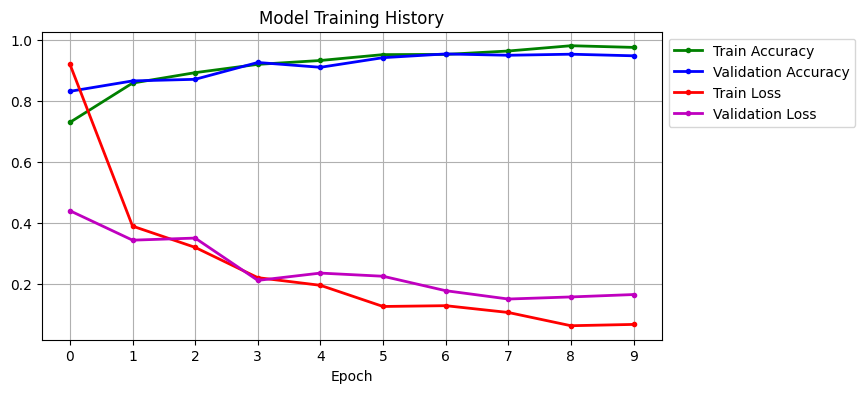

In [ ]:
#Plot VGG16 accuracy and loss for train and validation

plt.figure(figsize=(8, 4))
plt.grid(True)

# Plot training and validation accuracy
plt.plot(history_vgg.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history_vgg.history['val_sparse_categorical_accuracy'], '.b-', linewidth=2)

# Plot training and validation loss
plt.plot(history_vgg.history['loss'], '.r-', linewidth=2)
plt.plot(history_vgg.history['val_loss'], '.m-', linewidth=2)

plt.title('Model Training History')
plt.xlabel('Epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Train Accuracy', 'Validation Accuracy', 'Train Loss', 'Validation Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
#Validation
batch_size = 32
steps = len(X_test1) // batch_size  # Calculate the number of steps

y_pred = []
y_true = []

# Loop through test data in batches
for step in tqdm(range(steps)):
    start = step * batch_size
    end = (step + 1) * batch_size
    x_batch = X_test1[start:end]
    y_batch = y_test_int[start:end]

    pred = model.predict(x_batch)
    pred = np.argmax(pred, axis=-1)

    y_pred.extend(pred)
    y_true.extend(y_batch)

# Calculate accuracy
accuracy = np.sum(np.array(y_pred) == np.array(y_true)) / len(y_true)
print('Test accuracy:', accuracy)



  0%|          | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


  2%|▎         | 1/40 [00:01<01:14,  1.90s/it]

1/1 [==============================] - 0s 34ms/step


  5%|▌         | 2/40 [00:02<00:32,  1.18it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 3/40 [00:02<00:18,  1.96it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█         | 4/40 [00:02<00:12,  2.85it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▎        | 5/40 [00:02<00:09,  3.84it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 6/40 [00:02<00:07,  4.63it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 7/40 [00:02<00:06,  5.26it/s]

1/1 [==============================] - 0s 34ms/step


 20%|██        | 8/40 [00:02<00:05,  6.10it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▎       | 9/40 [00:02<00:04,  6.33it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 10/40 [00:02<00:04,  7.03it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 12/40 [00:03<00:03,  8.51it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▎      | 13/40 [00:03<00:03,  8.51it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 15/40 [00:03<00:02,  9.74it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▎     | 17/40 [00:03<00:02, 10.35it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 19/40 [00:03<00:02, 10.21it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▎    | 21/40 [00:03<00:01, 10.21it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▊    | 23/40 [00:04<00:01,  9.75it/s]

1/1 [==============================] - 0s 24ms/step


 60%|██████    | 24/40 [00:04<00:01,  9.59it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▌   | 26/40 [00:04<00:01,  9.79it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 27/40 [00:04<00:01,  9.44it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 28/40 [00:04<00:01,  9.29it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▎  | 29/40 [00:04<00:01,  8.98it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 30/40 [00:04<00:01,  8.96it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 31/40 [00:05<00:01,  8.90it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▎ | 33/40 [00:05<00:00,  9.35it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 35/40 [00:05<00:00, 10.09it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 36/40 [00:05<00:00,  9.67it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▌| 38/40 [00:05<00:00,  9.69it/s]

1/1 [==============================] - 0s 29ms/step


100%|██████████| 40/40 [00:05<00:00,  6.69it/s]

Test accuracy: 0.24765625


In [ ]:
#Create classification report

# Make predictions on the test data
y_pred_prob = model.predict(X_test1)

# Convert predicted probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# If your y_test is one-hot encoded, you may need to convert it to class labels as well
y_true = np.argmax(y_test1, axis=1)

# Define your class labels
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=categories)

# Print the classification report
print(report)

41/41 [==============================] - 3s 79ms/step
              precision    recall  f1-score   support

      glioma       0.94      0.96      0.95       300
  meningioma       0.95      0.88      0.91       306
     notumor       0.99      0.99      0.99       405
   pituitary       0.93      0.99      0.96       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.96      0.95      0.95      1311



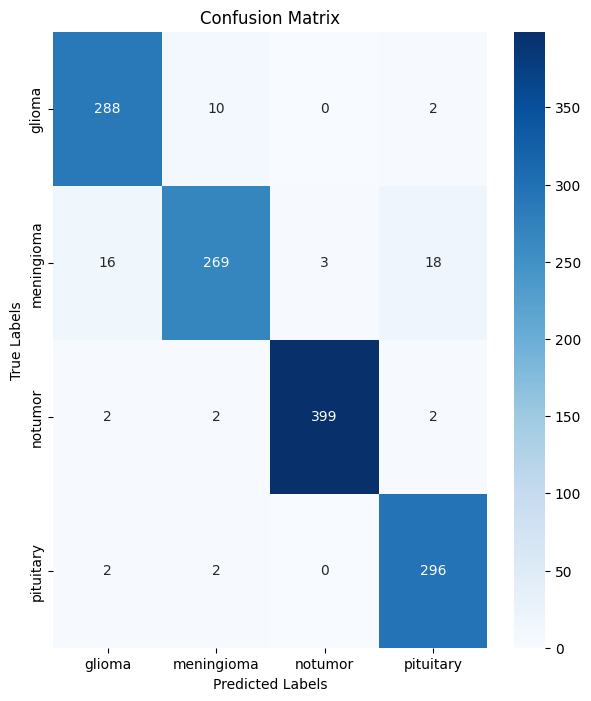

In [ ]:
#Create confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Define class labels (if you have specific class labels)
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']
class_labels = categories

# Create a heatmap using Seaborn
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

In [ ]:
# load VGG16 parameters into comparishon table

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Calculate precision
precision = precision_score(y_true, y_pred, average='weighted')  # or 'macro' or 'micro' depending on your needs

# Calculate recall
recall = recall_score(y_true, y_pred, average='weighted')  # or 'macro' or 'micro' depending on your needs

# Calculate F1 score
f1 = f1_score(y_true, y_pred, average='weighted')  # or 'macro' or 'micro' depending on your needs

# Store the results in a dictionary
result = {
        'Model Name': 'VGG16',
        'Accuracy': accuracy,
        'Recall': recall,
        'Precision': precision,
        'F1 Score': f1,
        'Training Time': training_time
    }

    # Append the result dictionary to the result_list
results.append(result)


# # Create a DataFrame from the results
df_results = pd.DataFrame(results)

# Display the DataFrame
df_results


Model Name  Accuracy    Recall  Precision  F1 Score  Training Time
0           CNN  0.896262  0.896262   0.897567  0.894621     138.524318
1  CNN +XGBoost  0.941266  0.941266   0.941632  0.940937     318.695272
2         VGG16  0.954996  0.954996   0.955457  0.954673     143.485373

# EfficientNetB3

### In general, the EfficientNet models achieve both higher accuracy and better efficiency over existing CNNs, reducing parameter size and FLOPS by an order of magnitude. EfficientNet scaling the networks depth, width and resolution simultaneously. This allows EfficientNet models to achive better accuracy while using fewer resourced compared to traditional approaches.

In [ ]:
print(X_train1.shape)
print(X_val1.shape)
print(X_test1.shape)
print(y_train1.shape)
print(y_val1.shape)
print(y_test1.shape)

(4569, 128, 128, 3)
(1143, 128, 128, 3)
(1311, 128, 128, 3)
(4569, 4)
(1143, 4)
(1311, 4)


##Callbacks : Helpful functions to help optimize model training

In [ ]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor # factor by which to reduce the learning rate
        self.batches = batches # number of training batch to run per epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch # save this value to restore if restarting training

        # callback variables
        self.count = 0 # how many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1   # epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initial learning rate and save it
        self.highest_tracc = 0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf # set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights = self.model.get_weights()   # save initial weights if they have to get restored

    # Define a function that will run when train begins
    def on_train_begin(self, logs= None):
        msg = 'Do you want model asks you to halt the training [y/n] ?'
        print(msg)
        ans = input('')
        if ans == 'Y' or ans == 'y':
            self.ask_permission = 1
        elif ans == 'N' or ans == 'n':
            self.ask_permission = 0

        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()


    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)

        # set the weights of the model to the best weights
        self.model.set_weights(self.best_weights)


    def on_train_batch_end(self, batch, logs= None):
        # get batch accuracy and loss
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')

        # prints over on the same line to show running batch count
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '')


    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()


    # Define method runs on the end of each epoch
    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr = lr
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        loss = logs.get('loss')  # get training loss for this epoch
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch

        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # define improvement of model progres

            if acc > self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc = acc # set new highest training accuracy
                self.best_weights = self.model.get_weights() # training accuracy improved so save the weights
                self.count = 0 # set count to 0 since training accuracy improved
                self.stop_count = 0 # set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # set the value of best epoch for this epoch

            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count >= self.patience - 1: # lr should be adjusted
                    lr = lr * self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count = 0 # reset the count to 0
                    self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count = 0 # reset counter
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 # increment patience counter

        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss
            if v_loss < self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss = v_loss # replace lowest validation loss with new validation loss
                self.best_weights = self.model.get_weights() # validation loss improved so save the weights
                self.count = 0 # reset count since validation loss improved
                self.stop_count = 0
                self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch
            else: # validation loss did not improve
                if self.count >= self.patience - 1: # need to adjust lr
                    lr = lr * self.factor # adjust the learning rate
                    self.stop_count = self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count = 0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                else:
                    self.count = self.count + 1 # increment the patience counter
                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True # stop training

        else:
            if self.ask_epoch != None and self.ask_permission != 0:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                    print(msg)
                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True # stop training
                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f' training will continue until epoch ' + str(self.ask_epoch)
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                            print(msg)
                        except:
                            print('Invalid')

##Model creation - pretrained model EfficientNetB3

In [ ]:
# Create Model Structure
img_size = (128, 128)
channels = 3
img_shape = (img_size[0], img_size[1], channels)


# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= (img_shape), pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(4, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

43941136/43941136 [==============================] - 3s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization (BatchN  (None, 1536)             6144      
 ormalization)                                                   
                                                                 
 dense_4 (Dense)             (None, 256)               393472    
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 11,184,179
Trainable params: 11,093,804
N

### Set callback parameters

In [ ]:
batch_size = 40     # set batch size for training
epochs = 15         # number of all epochs in training
patience = 1 		    # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 3 	# number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9 	  # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor = 0.5 		    # factor to reduce lr by
ask_epoch = 5		    # number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(y_train1) / batch_size))    # number of training batch to run per epoch

callbacks = [MyCallback(model= model, patience= patience,
            stop_patience= stop_patience, threshold= threshold, factor= factor,
            batches= batches, epochs= epochs, ask_epoch= ask_epoch )]

##Train model

In [ ]:
start_time = time.time()

history_en = model.fit(
    x=X_train1,  # Training data
    y=y_train1,  # Training labels
    epochs=epochs,
    verbose=0,
    callbacks=callbacks,
    validation_data=(X_val1, y_val1),  # Validation data
    shuffle=False  # No need to shuffle if you're using arrays
)


training_time = time.time() - start_time

Do you want model asks you to halt the training [y/n] ?
n
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /15     6.762   83.432   5.38774  88.189   0.00100  0.00100  accuracy     0.00    119.11 
 2 /15     4.168   94.069   3.42419  94.226   0.00100  0.00100  val_loss    36.44    26.26  
 3 /15     2.743   97.199   2.25179  96.325   0.00100  0.00100  val_loss    34.24    24.98  
 4 /15     1.802   98.709   1.49057  97.025   0.00100  0.00100  val_loss    33.81    26.61  
 5 /15     1.179   99.256   0.97980  97.375   0.00100  0.00100  val_loss    34.27    25.05  
 6 /15     0.774   99.672   0.67135  97.463   0.00100  0.00100  val_loss    31.48    25.00  
 7 /15     0.520   99.759   0.47937  97.288   0.00100  0.00100  val_loss    28.60    25.94  
 8 /15     0.365   99.737   0.34194  98.075   0.00100  0.00100  val_loss    28.67    26.16  
 9 /15     0.265   99.956   0.27184  97.988   0.00100  0.00100  val_loss    20.50    26.35  
10 /15     0.

##Visualize the training loss and accuracy of train and validation

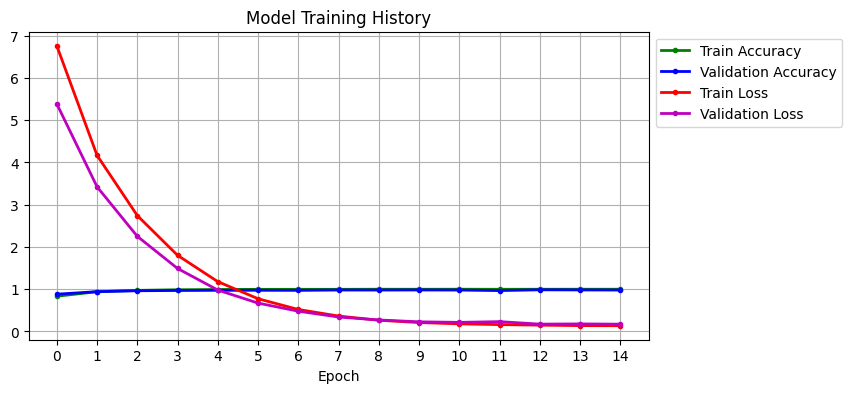

In [ ]:
plt.figure(figsize=(8, 4))
plt.grid(True)

# Plot training and validation accuracy
plt.plot(history_en.history['accuracy'], '.g-', linewidth=2)
plt.plot(history_en.history['val_accuracy'], '.b-', linewidth=2)

# Plot training and validation loss
plt.plot(history_en.history['loss'], '.r-', linewidth=2)
plt.plot(history_en.history['val_loss'], '.m-', linewidth=2)

plt.title('Model Training History')
plt.xlabel('Epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Train Accuracy', 'Validation Accuracy', 'Train Loss', 'Validation Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

##Validation

In [ ]:
ts_length = len(y_test1)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(X_train1, y_train1, steps=test_steps, verbose=1)
valid_score = model.evaluate(X_val1, y_val1, steps=test_steps, verbose=1)
test_score = model.evaluate(X_test1, y_test1, steps=test_steps, verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])


19/19 [==============================] - 2s 82ms/step - loss: 0.1852 - accuracy: 0.9794
Train Loss:  0.11496691405773163
Train Accuracy:  0.9995622634887695
--------------------
Validation Loss:  0.17238719761371613
Validation Accuracy:  0.9798775315284729
--------------------
Test Loss:  0.18517521023750305
Test Accuracy:  0.9794050455093384


In [ ]:
preds = model.predict_generator(X_test1)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

<ipython-input-59-f6606ec644b2>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(X_test1)


[0 0 0 ... 3 3 3]


##Create classification report

In [ ]:
# Make predictions on the test data
y_pred_prob = model.predict(X_test1)

# Convert predicted probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# If your y_test is one-hot encoded, you may need to convert it to class labels as well
y_true = np.argmax(y_test1, axis=1)

# Define your class labels
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=categories)

# Print the classification report
print(report)

41/41 [==============================] - 2s 39ms/step
              precision    recall  f1-score   support

      glioma       0.99      0.96      0.97       300
  meningioma       0.95      0.96      0.96       306
     notumor       0.99      1.00      0.99       405
   pituitary       0.98      0.99      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



## Create confusion matrix

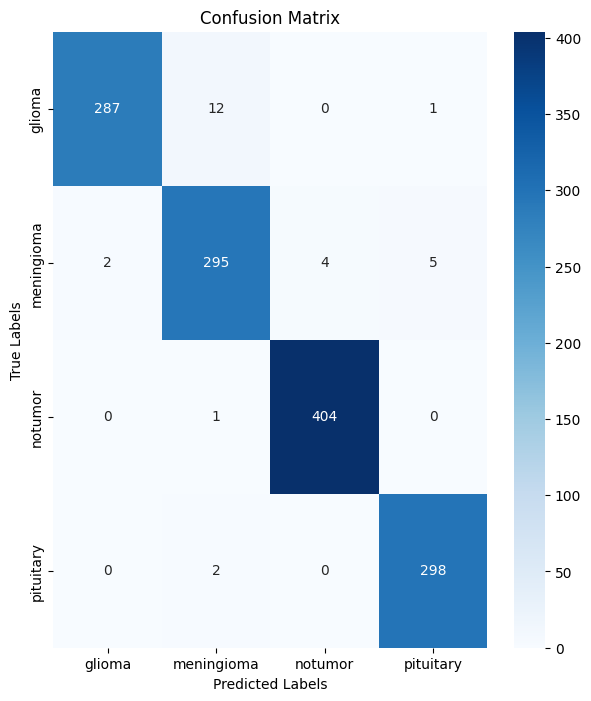

In [ ]:
conf_matrix = confusion_matrix(y_true, y_pred)

# Define class labels (if you have specific class labels)
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']
class_labels = categories

# Create a heatmap using Seaborn
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

## Add EfficiencyNet parameters to comparishon table

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Calculate precision
precision = precision_score(y_true, y_pred, average='weighted')  # or 'macro' or 'micro' depending on your needs

# Calculate recall
recall = recall_score(y_true, y_pred, average='weighted')  # or 'macro' or 'micro' depending on your needs

# Calculate F1 score
f1 = f1_score(y_true, y_pred, average='weighted')  # or 'macro' or 'micro' depending on your needs

# Store the results in a dictionary
result = {
        'Model Name': 'EfficientNetB3',
        'Accuracy': accuracy,
        'Recall': recall,
        'Precision': precision,
        'F1 Score': f1,
        'Training Time': training_time
    }

    # Append the result dictionary to the result_list
results.append(result)


# # Create a DataFrame from the results
df_results = pd.DataFrame(results)

# Display the DataFrame
df_results

Model Name  Accuracy    Recall  Precision  F1 Score  Training Time
0             CNN  0.896262  0.896262   0.897567  0.894621     138.524318
1    CNN +XGBoost  0.941266  0.941266   0.941632  0.940937     318.695272
2           VGG16  0.954996  0.954996   0.955457  0.954673     143.485373
3  EfficientNetB3  0.979405  0.979405   0.979577  0.979390     488.088006

## **The conclusion :**
## Every addition to CNN has improved the initial performance. EffectiveNetB3 is really the best of all with highest number of trainable parameters and longest training time.

## Display the incorrectly predicted images

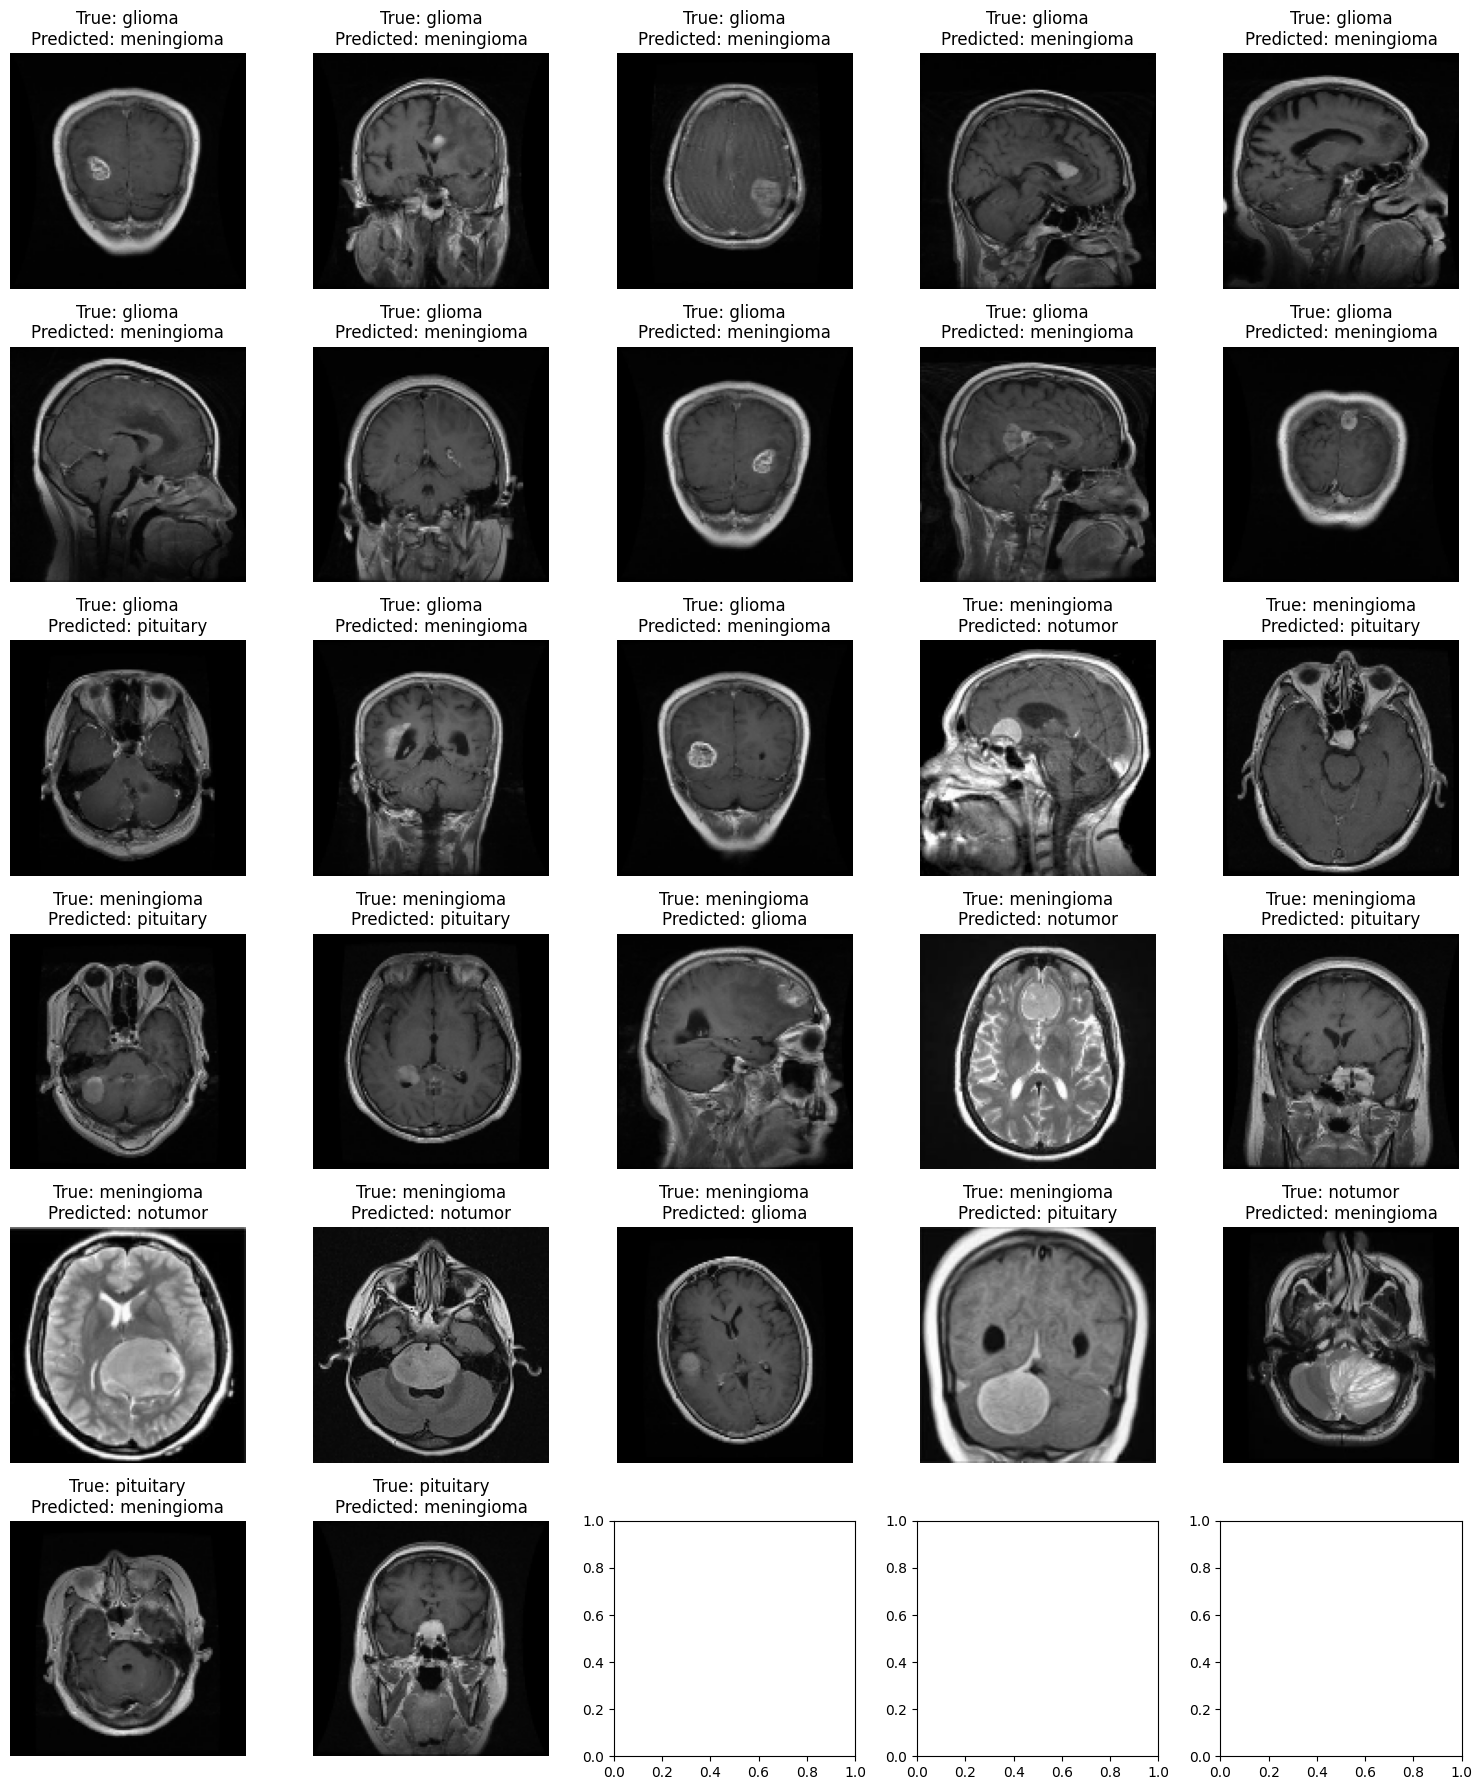

In [ ]:
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']
incorrect_indices = np.where(y_pred != y_test1.argmax(axis=1))[0]

images_per_row = 5  # Number of images to display per row
num_rows = int(np.ceil(len(incorrect_indices) / images_per_row))

fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, 3*num_rows))

for i, index in enumerate(incorrect_indices):
    predicted_label = y_pred[index]
    true_label = y_test1[index].argmax()

    row = i // images_per_row
    col = i % images_per_row

    ax = axes[row, col]
    ax.imshow(X_test1[index])
    ax.set_title(f"True: {categories[true_label]}\nPredicted: {categories[predicted_label]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

#**The conclusion**
##Our model predicts the probability of each image to belong to one of the 4 classes. It mistakes in 2% of the cases, however, we have ~20 images per person in our data. Although, we don't have the information which images belong to which person, in real world this information is available allowing us to group images by patients. In this case 1-2 mistakes may be present in each patient but most of the images will have the correct prediction. Thus, we can extract the  "majority voting" in each patient and the model will always predict correctly per patient !  Which is our goal in real life.